In [13]:
# class that inherits from property based test
import numpy as np
import csv
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from sympy.printing.pretty.pretty_symbology import line_width

from qucheck.property import Property
from qucheck.input_generators import RandomState
from qucheck.test_runner import TestRunner

In [14]:
def read_merged_data_to_dataframe(algorithm_name):
    # Define the directory where the CSV files are stored
    filename = f"mutation_test_results/{algorithm_name}/{algorithm_name}_merged_results.csv"
    return pd.read_csv(filename)

In [15]:
qt_df = read_merged_data_to_dataframe("quantum_teleportation")
dj_df = read_merged_data_to_dataframe("deutsch_jozsa")
qft_df = read_merged_data_to_dataframe("quantum_fourier_transform")
qpe_df = read_merged_data_to_dataframe("quantum_phase_estimation")
grover_df = read_merged_data_to_dataframe("grovers_algorithm")

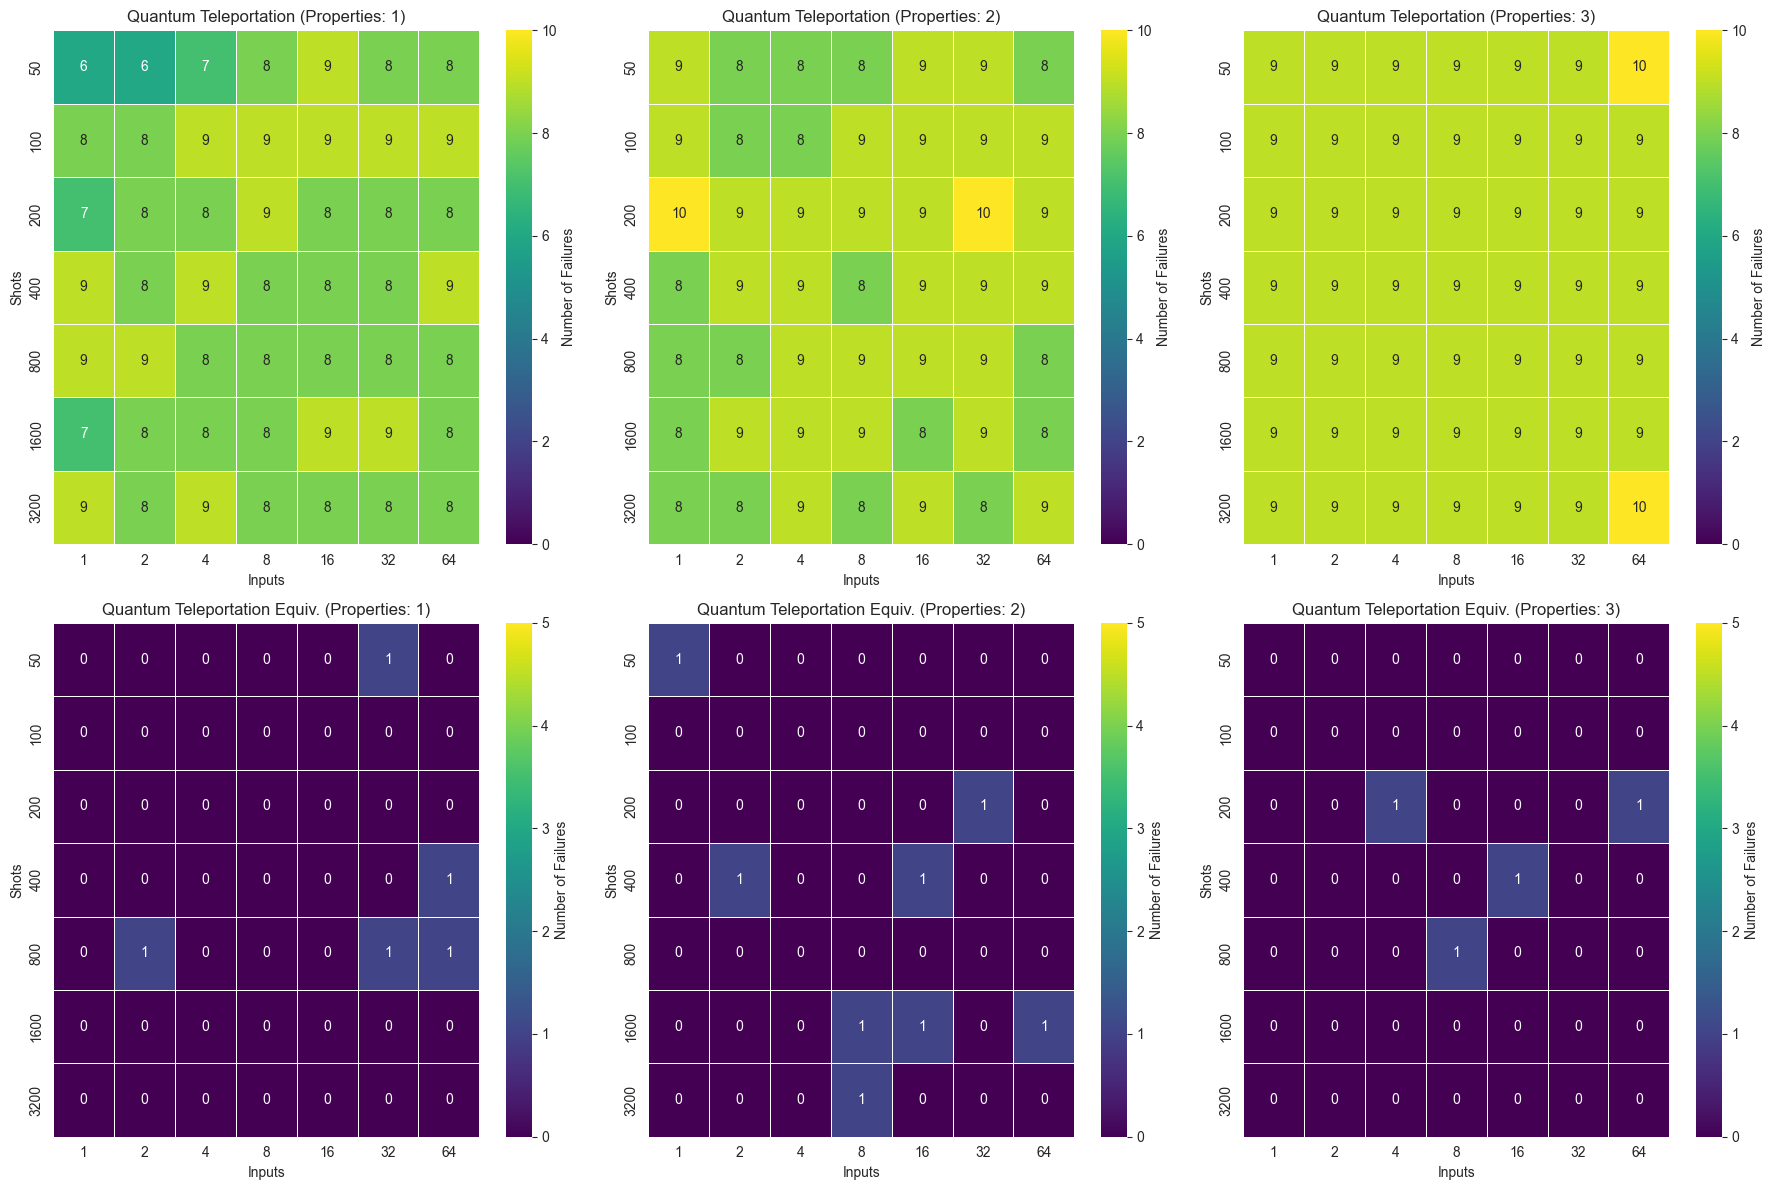

In [16]:
def plot_failures(df, algorithm_name):
    df_non_equivalent = df[df['Mutant Name'].str.contains('_m')]
    df_equivalent = df[df['Mutant Name'].str.contains('_em')]
    
    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # viridis or magma
    palette = sns.color_palette("viridis", as_cmap=True)

    # Plot heatmaps for non-equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Result'].apply(lambda x: (x == 'Fail').sum()).unstack()
        
        sns.heatmap(failure_rate, annot=True, cmap=palette, ax=axes[0, i], fmt='d', 
                    linewidth=0.5, vmin=0, vmax=10, cbar_kws={'label': 'Number of Failures'}, 
                    annot_kws={"size": 10})
        axes[0, i].set_title(f'{algorithm_name} (Properties: {num_properties})')
        axes[0, i].set_xlabel('Inputs')
        axes[0, i].set_ylabel('Shots')

    # Plot heatmaps for equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        pass_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Result'].apply(lambda x: (x == 'Fail').sum()).unstack()
        
        sns.heatmap(pass_rate, annot=True, cmap=palette, ax=axes[1, i], fmt='d', 
                    linewidth=0.5, vmin=0, vmax=5, cbar_kws={'label': 'Number of Failures'}, 
                    annot_kws={"size": 10})
        axes[1, i].set_title(f'{algorithm_name} Equiv. (Properties: {num_properties})')
        axes[1, i].set_xlabel('Inputs')
        axes[1, i].set_ylabel('Shots')

    plt.tight_layout()
    plt.savefig(f"{algorithm_name}_failures_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

plot_failures(qt_df, "Quantum Teleportation")

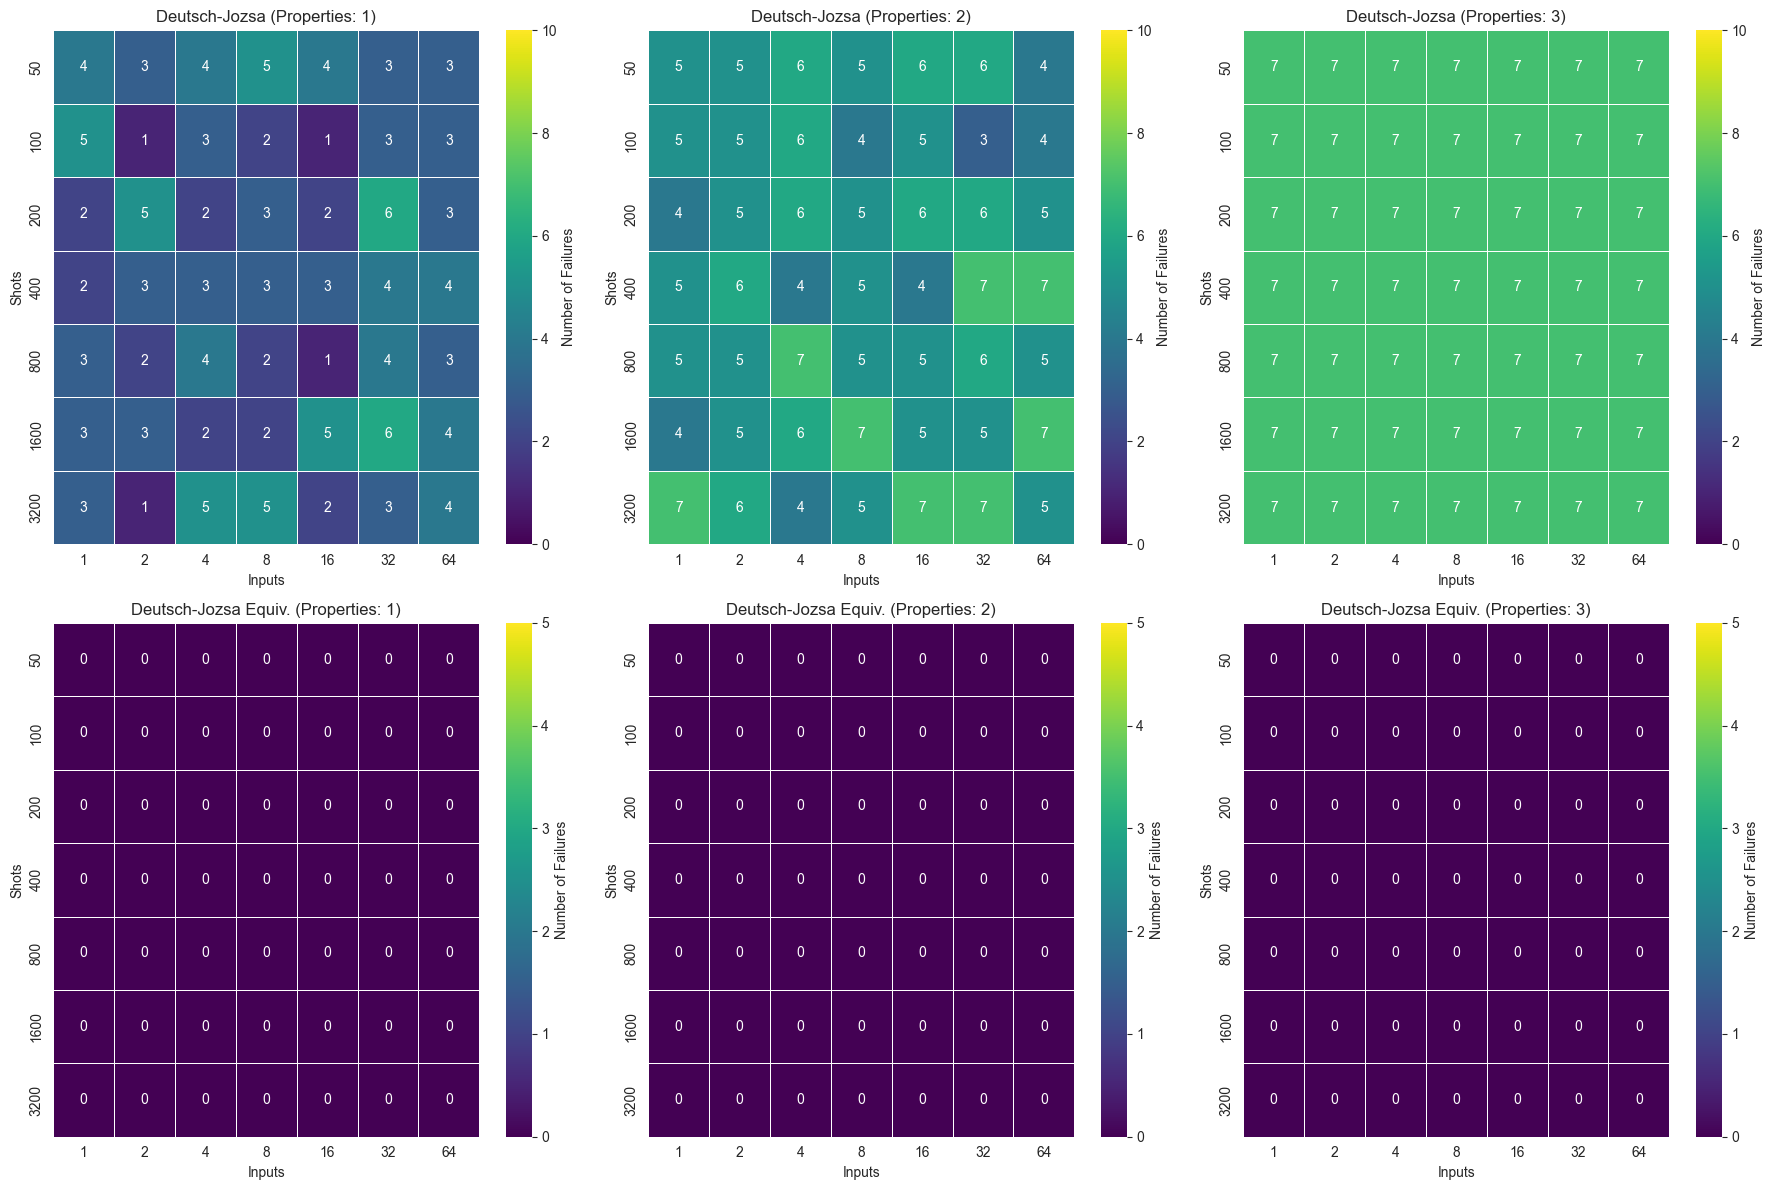

In [17]:
plot_failures(dj_df, "Deutsch-Jozsa")

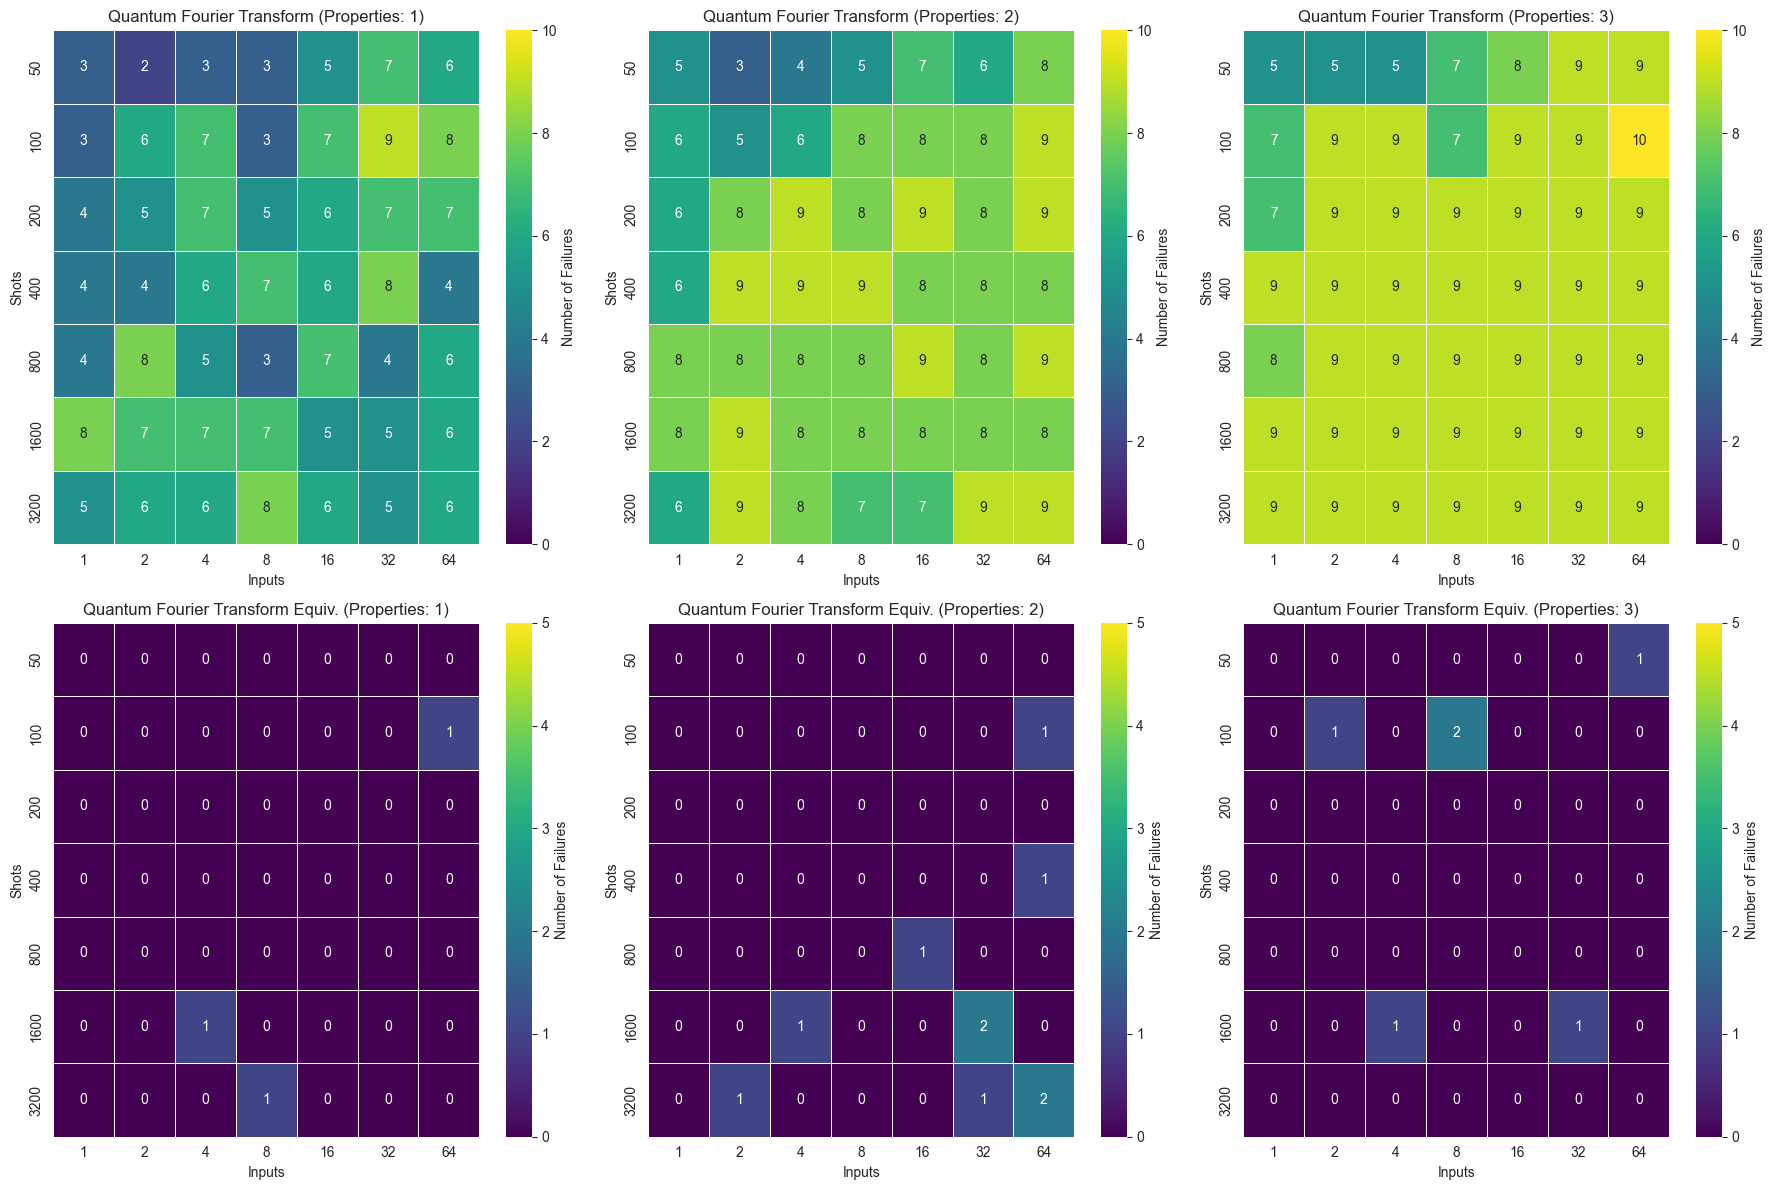

In [18]:
plot_failures(qft_df, "Quantum Fourier Transform")

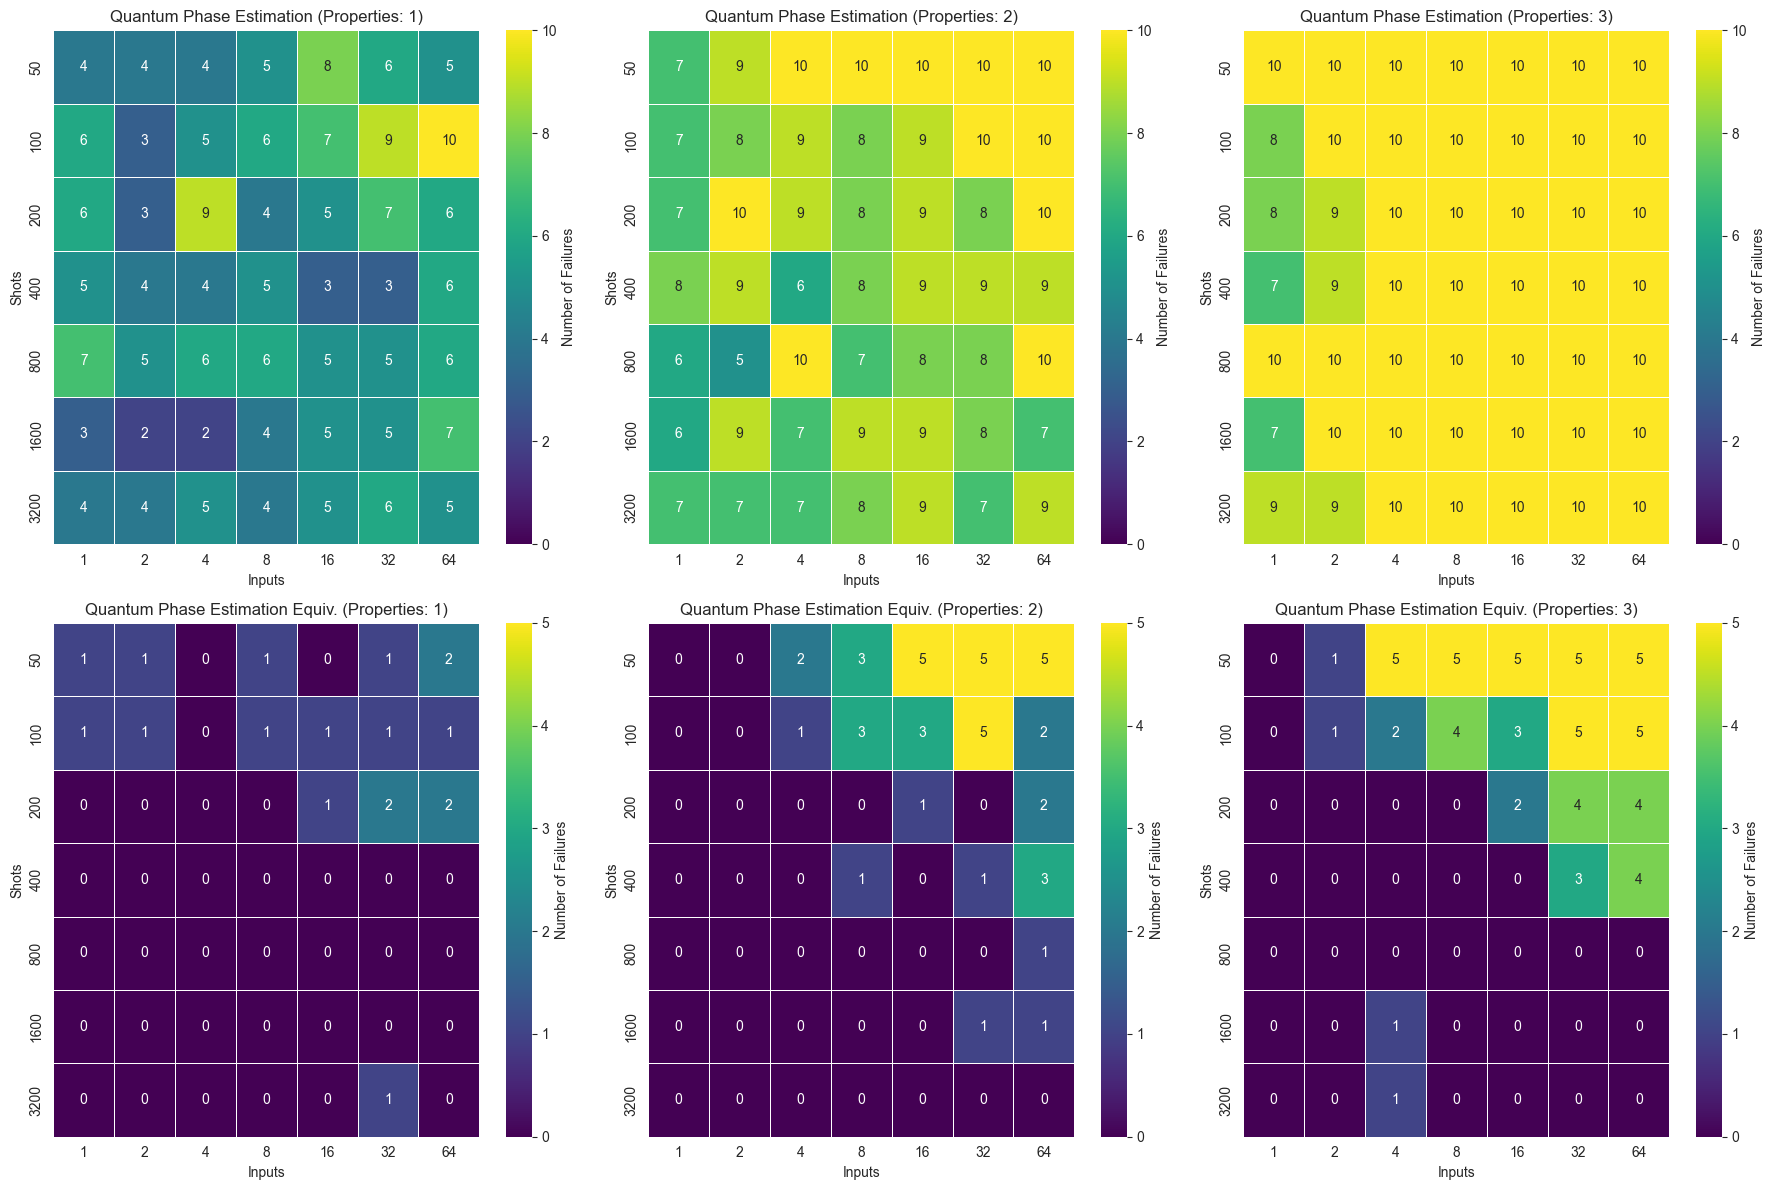

In [19]:
plot_failures(qpe_df, "Quantum Phase Estimation")

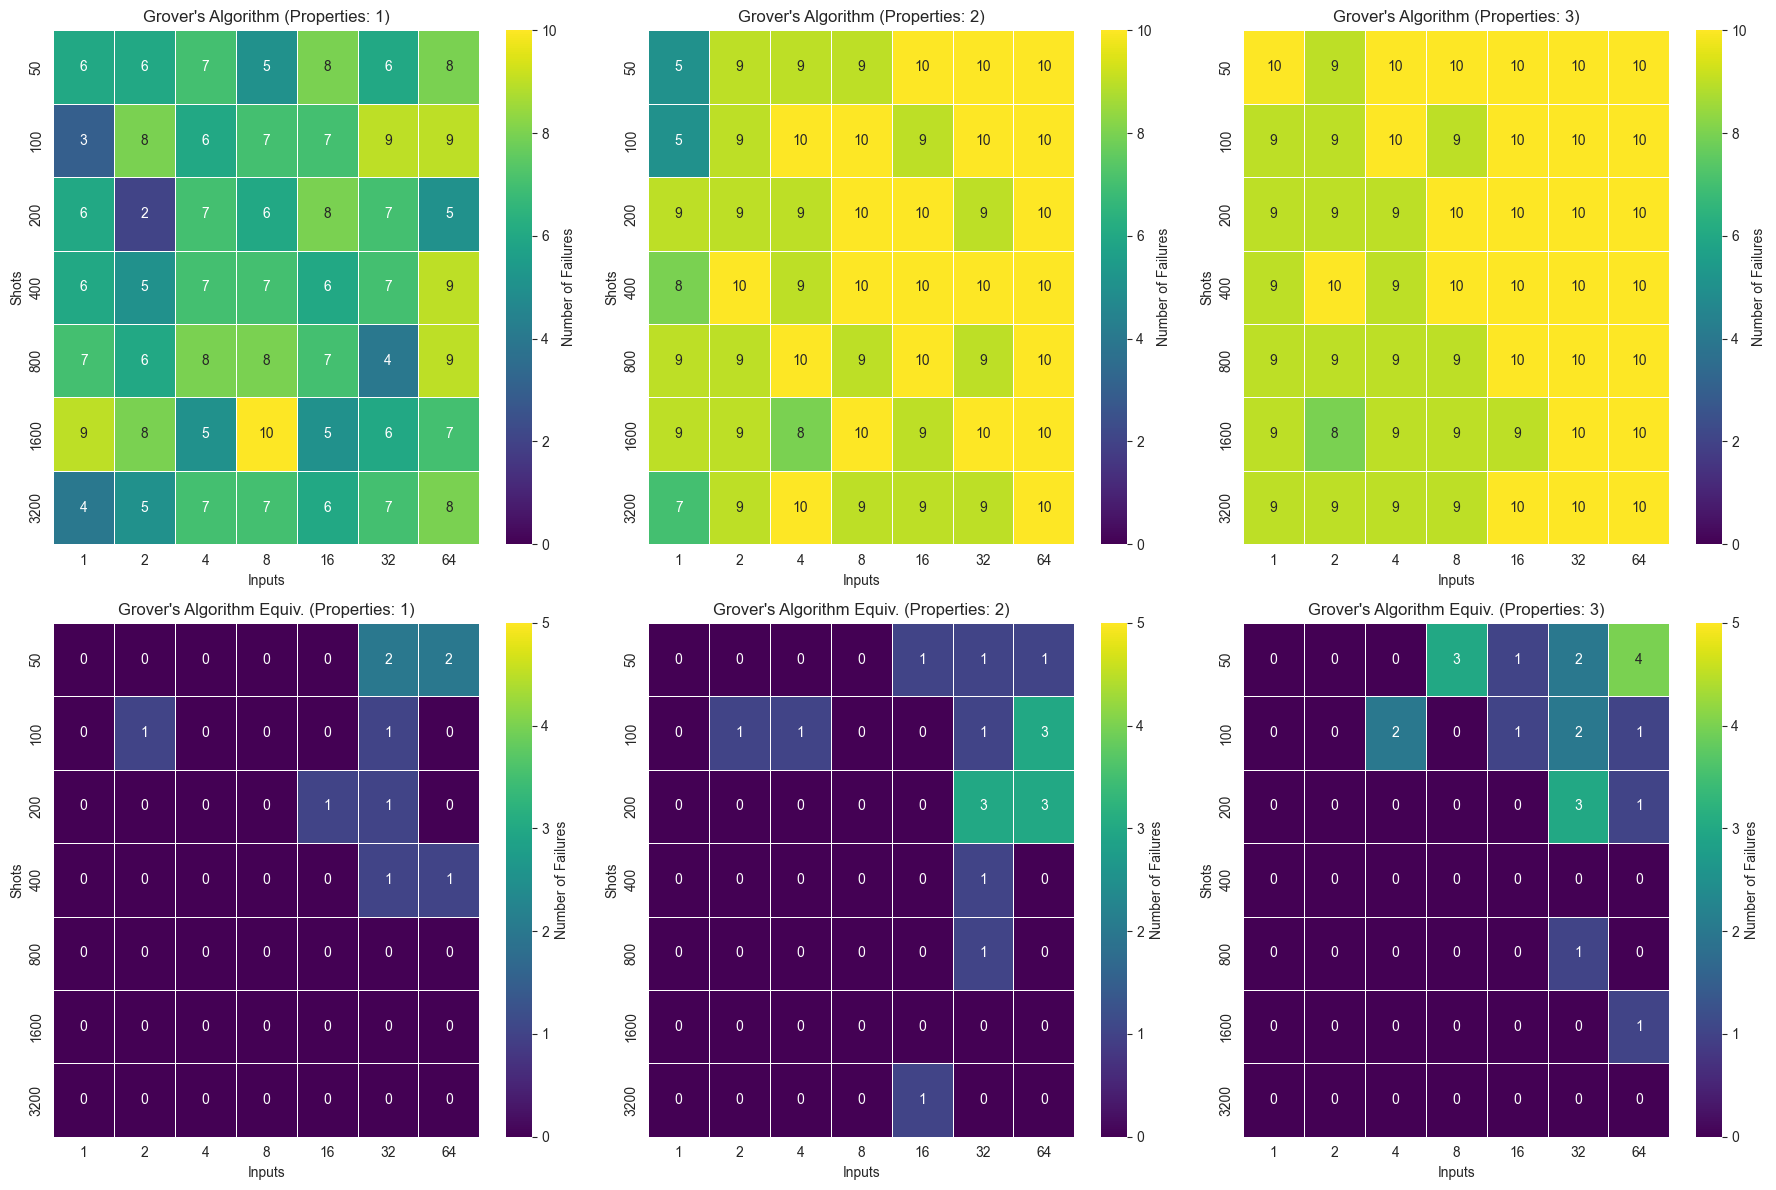

In [20]:
plot_failures(grover_df, "Grover's Algorithm")

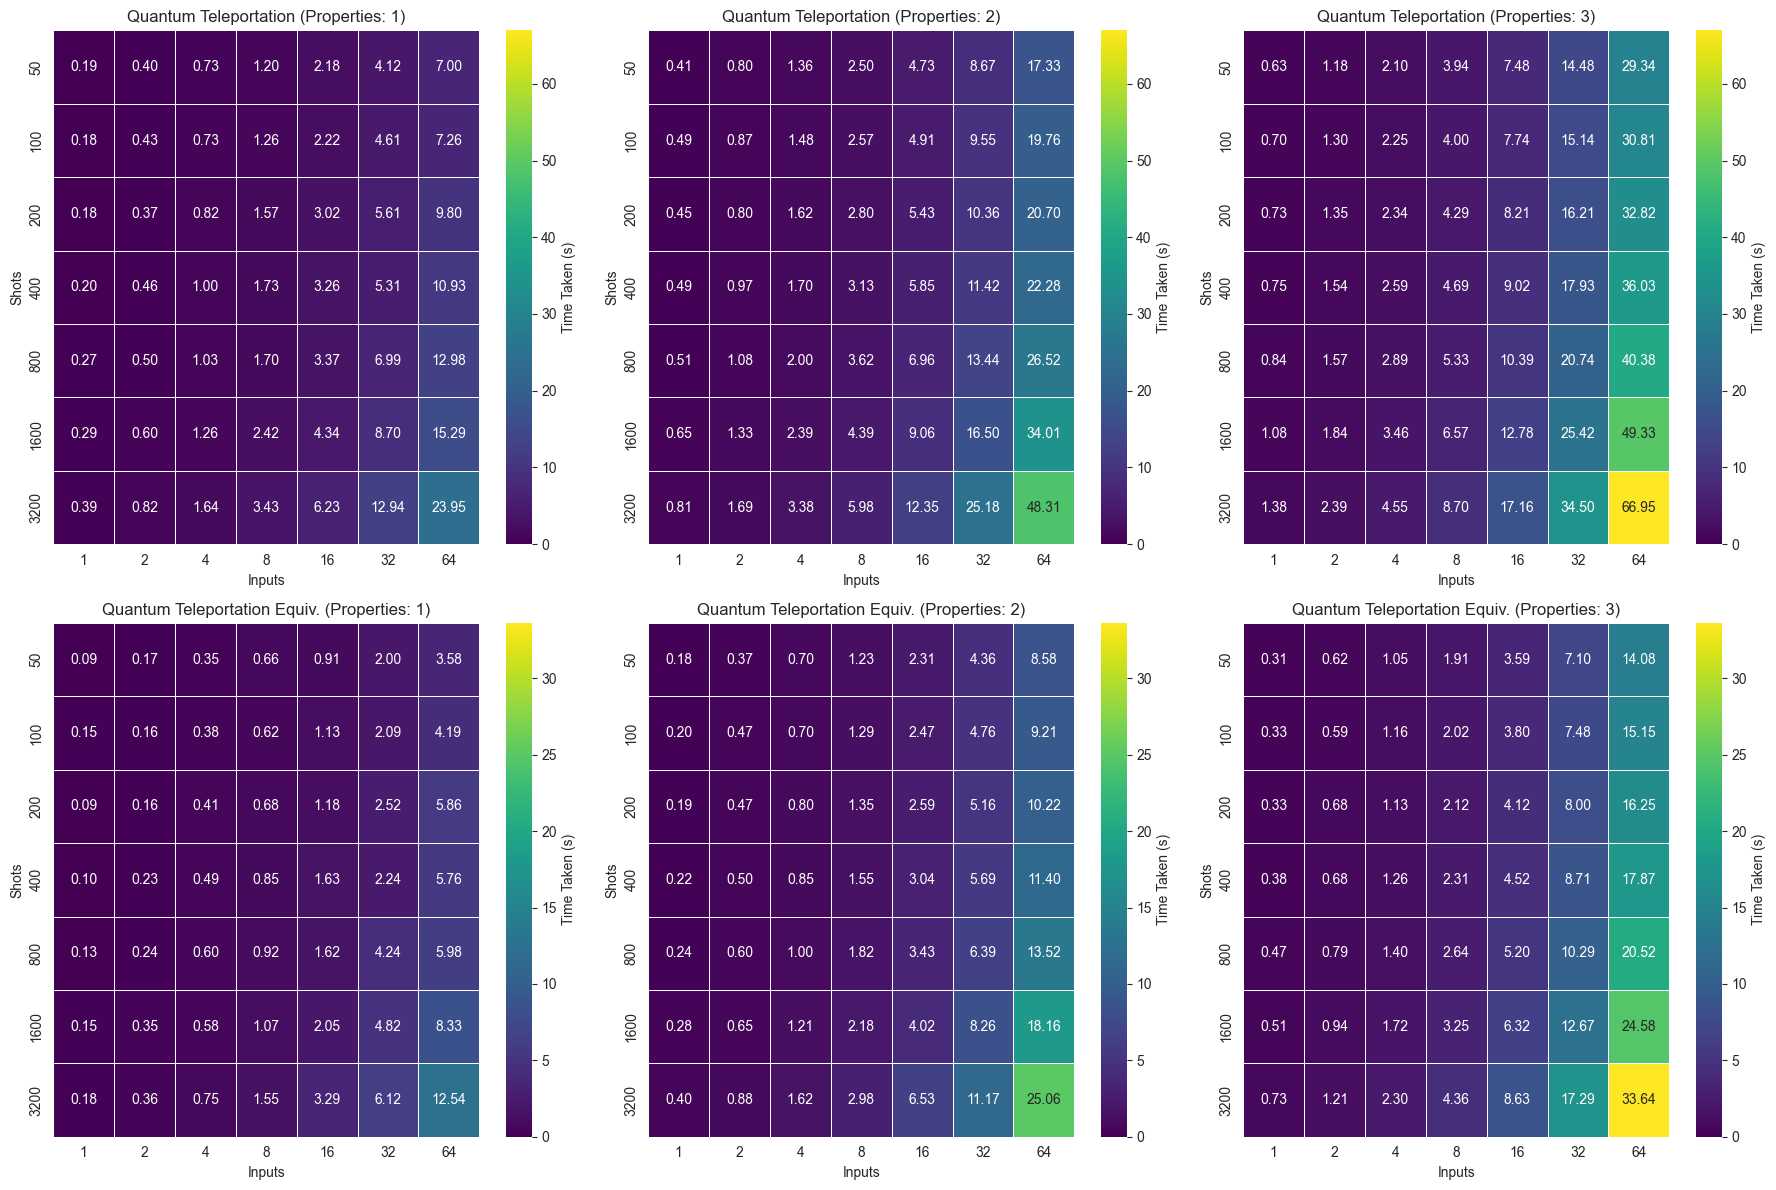

In [21]:
def plot_time_taken(df, algorithm_name):
    df_non_equivalent = df[df['Mutant Name'].str.contains('_m')]
    df_equivalent = df[df['Mutant Name'].str.contains('_em')]
    
    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # viridis or magma
    palette = sns.color_palette("viridis", as_cmap=True)

    sum_non_equiv_times = []
    # store the max sum time taken non equivalent
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        # get the largest value from the unstacked dataframe
        largest_value = failure_rate.max().max()
        sum_non_equiv_times.append(largest_value)
    max_time_non_equiv = max(sum_non_equiv_times)
        
    sum_equiv_times = []
    # store the max sum time taken equivalent
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        largest_value = failure_rate.max().max()
        sum_equiv_times.append(largest_value)
    max_time_equiv = max(sum_equiv_times)
        

    # Plot heatmaps for non-equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        
        sns.heatmap(failure_rate, annot=True, cmap=palette, ax=axes[0, i], fmt='.2f', 
                    linewidth=0.5, vmin=0, vmax=max_time_non_equiv, cbar_kws={'label': 'Time Taken (s)'}, 
                    annot_kws={"size": 10})
        axes[0, i].set_title(f'{algorithm_name} (Properties: {num_properties})')
        axes[0, i].set_xlabel('Inputs')
        axes[0, i].set_ylabel('Shots')

    # Plot heatmaps for equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        pass_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        
        sns.heatmap(pass_rate, annot=True, cmap=palette, ax=axes[1, i], fmt='.2f', 
                    linewidth=0.5, vmin=0, vmax=max_time_equiv, cbar_kws={'label': 'Time Taken (s)'}, 
                    annot_kws={"size": 10})
        axes[1, i].set_title(f'{algorithm_name} Equiv. (Properties: {num_properties})')
        axes[1, i].set_xlabel('Inputs')
        axes[1, i].set_ylabel('Shots')

    plt.tight_layout()
    plt.savefig(f"{algorithm_name}_time_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

plot_time_taken(qt_df, "Quantum Teleportation")

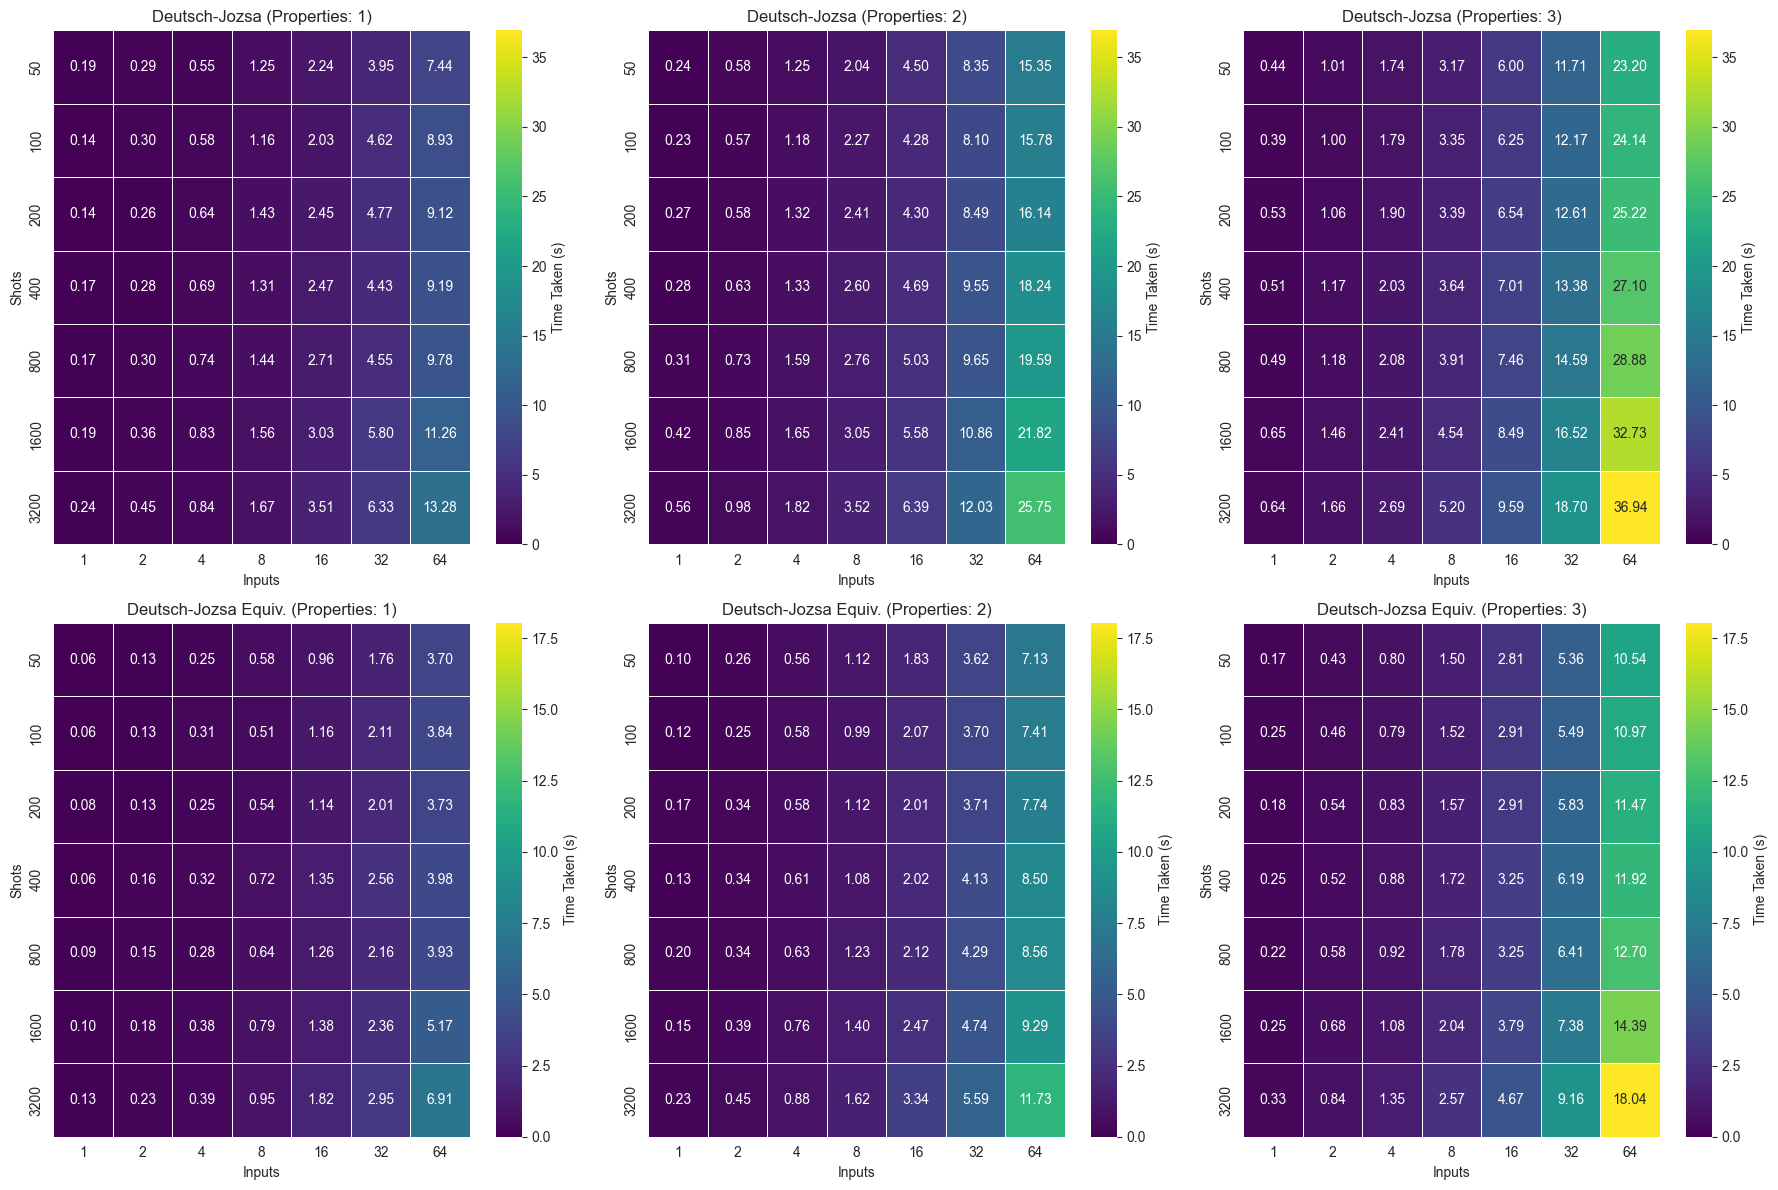

In [22]:
plot_time_taken(dj_df, "Deutsch-Jozsa")

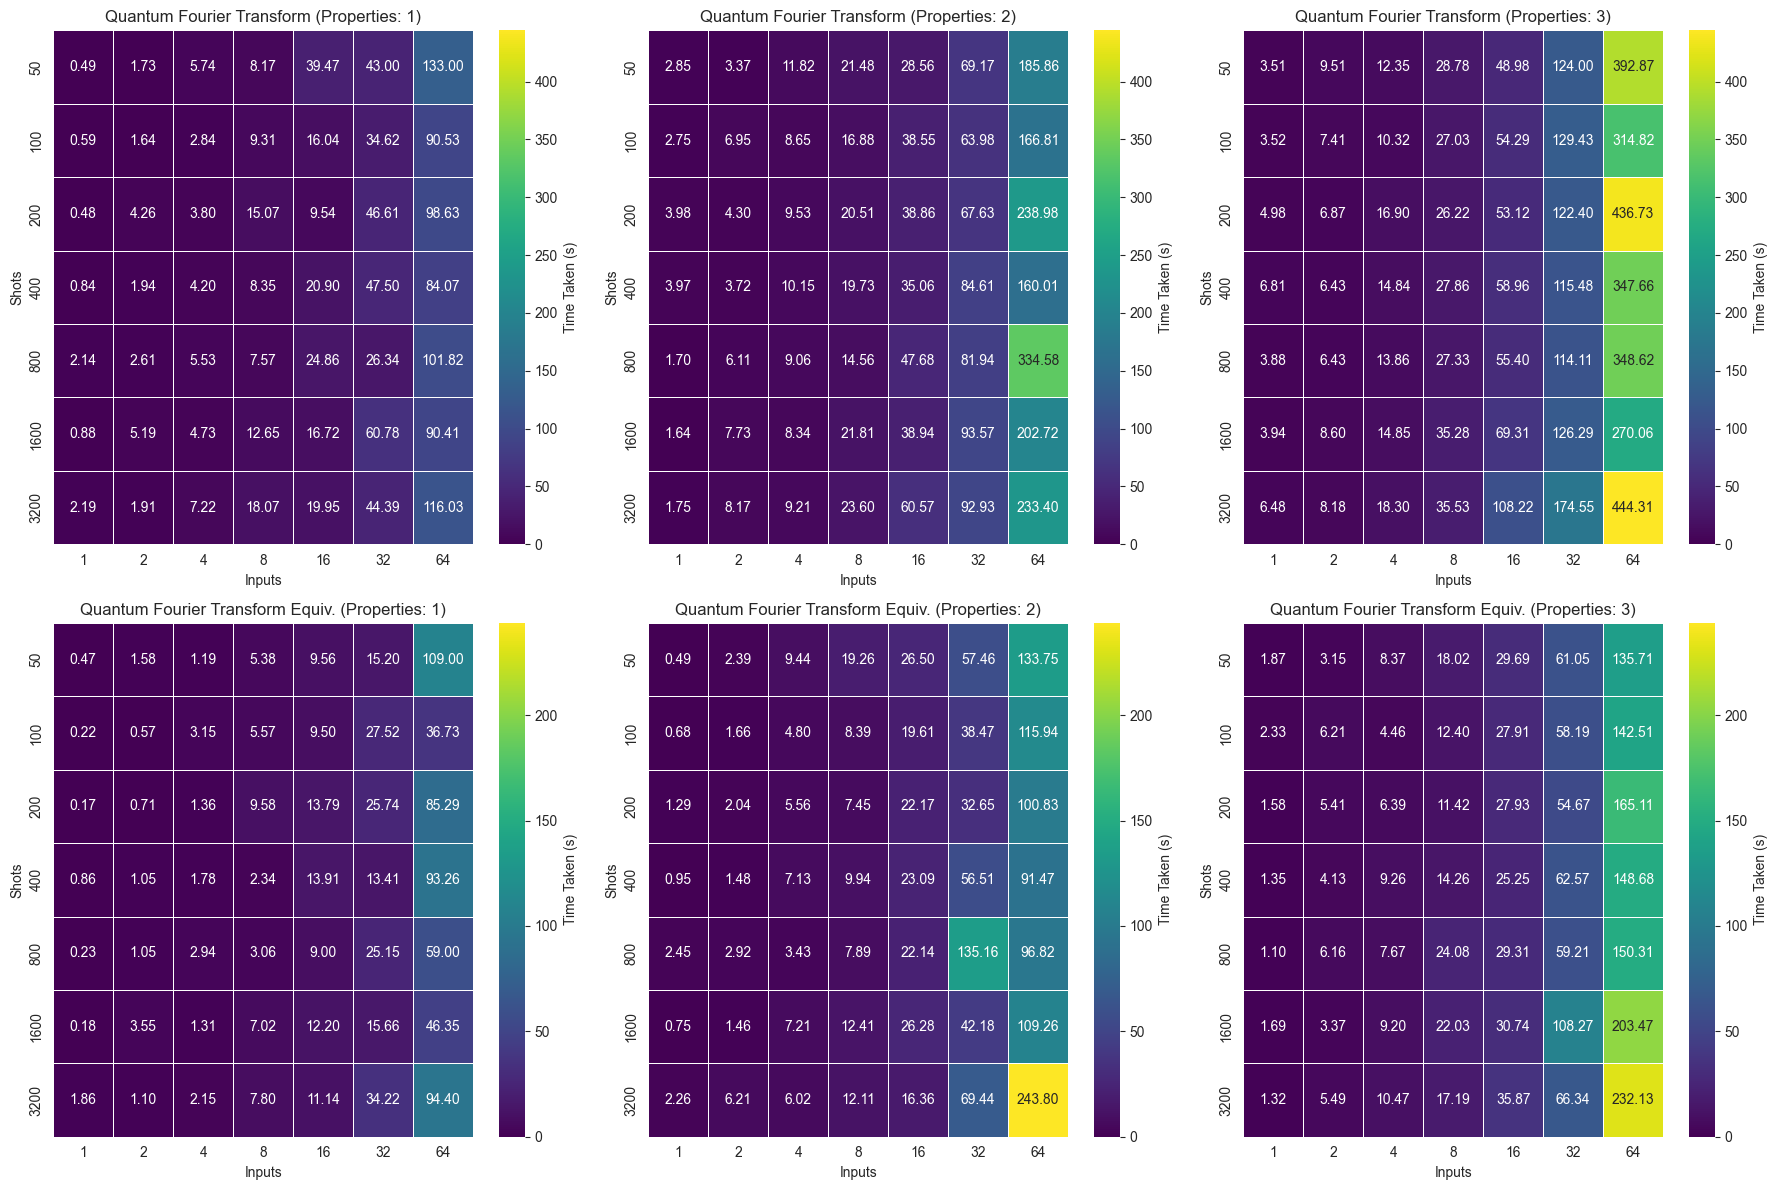

In [23]:
plot_time_taken(qft_df, "Quantum Fourier Transform")

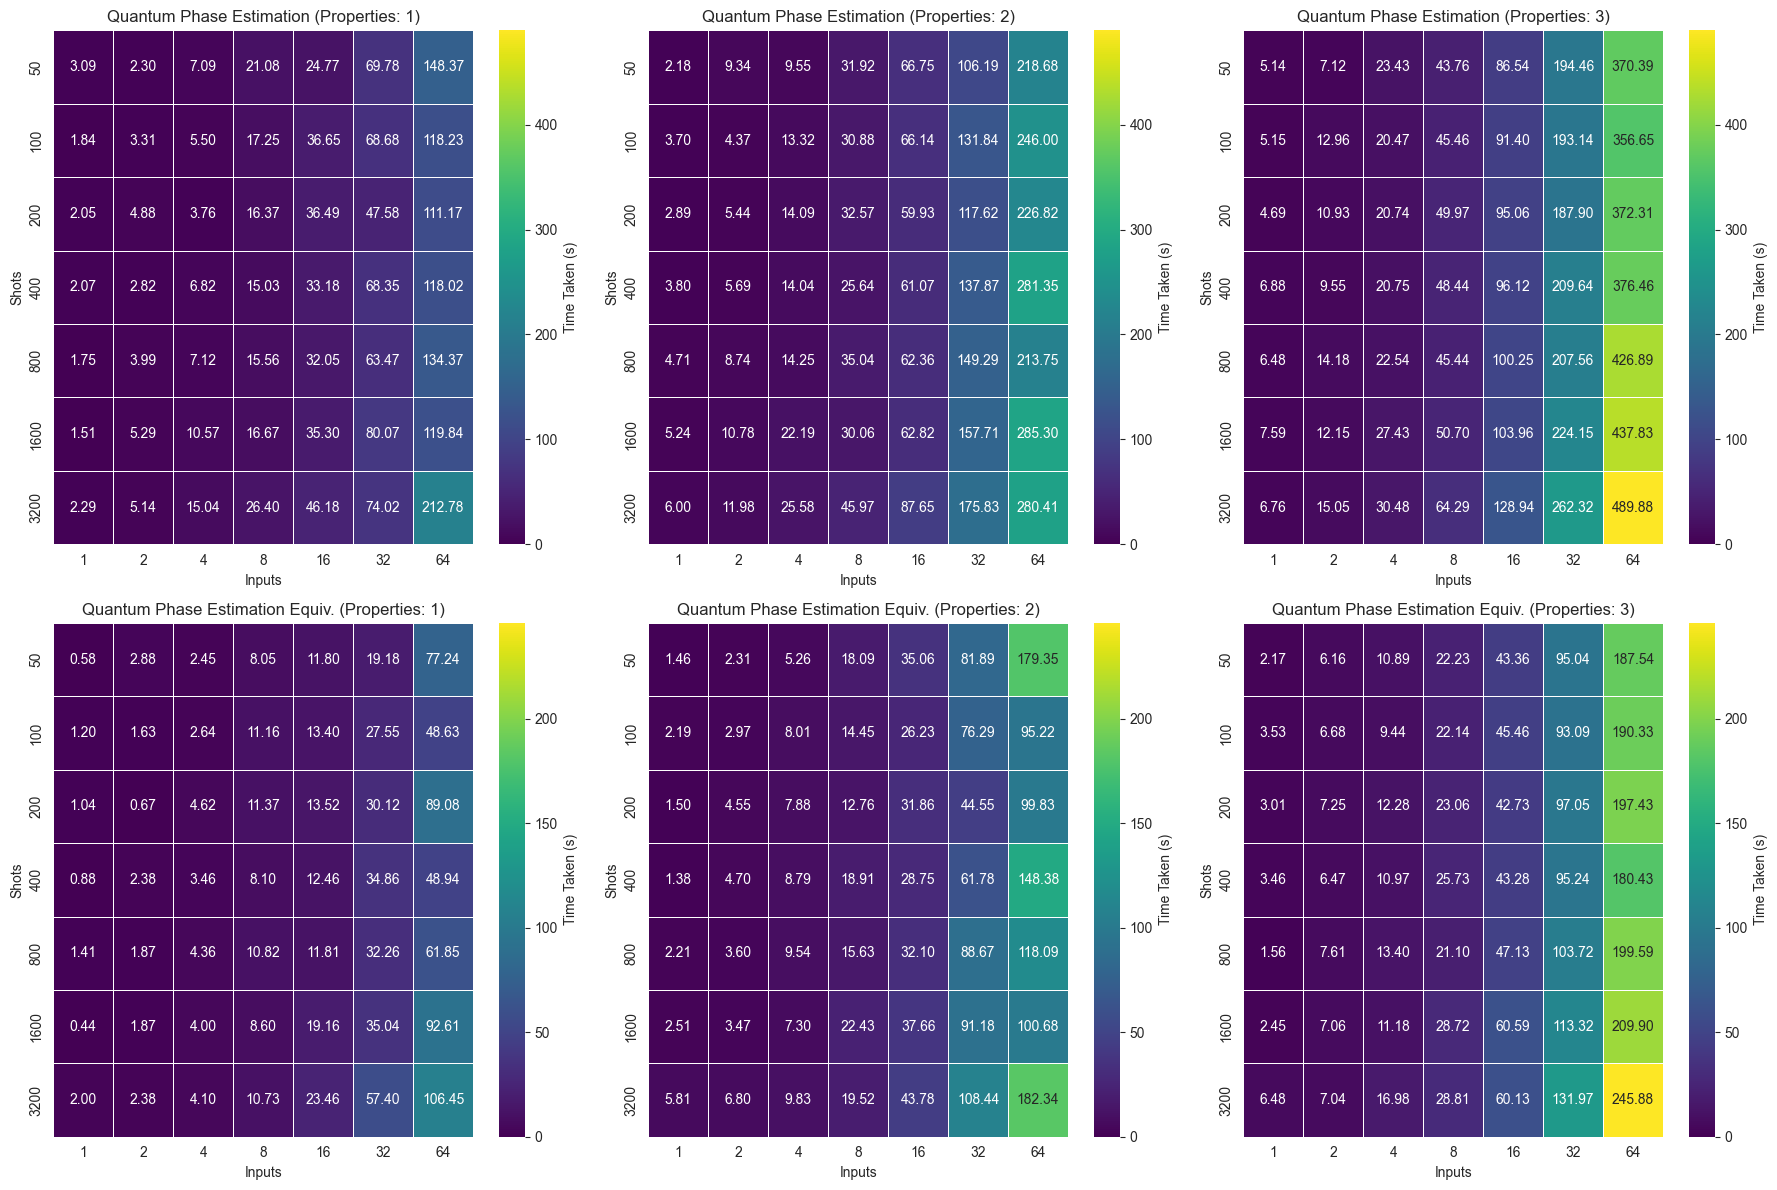

In [24]:
plot_time_taken(qpe_df, "Quantum Phase Estimation")

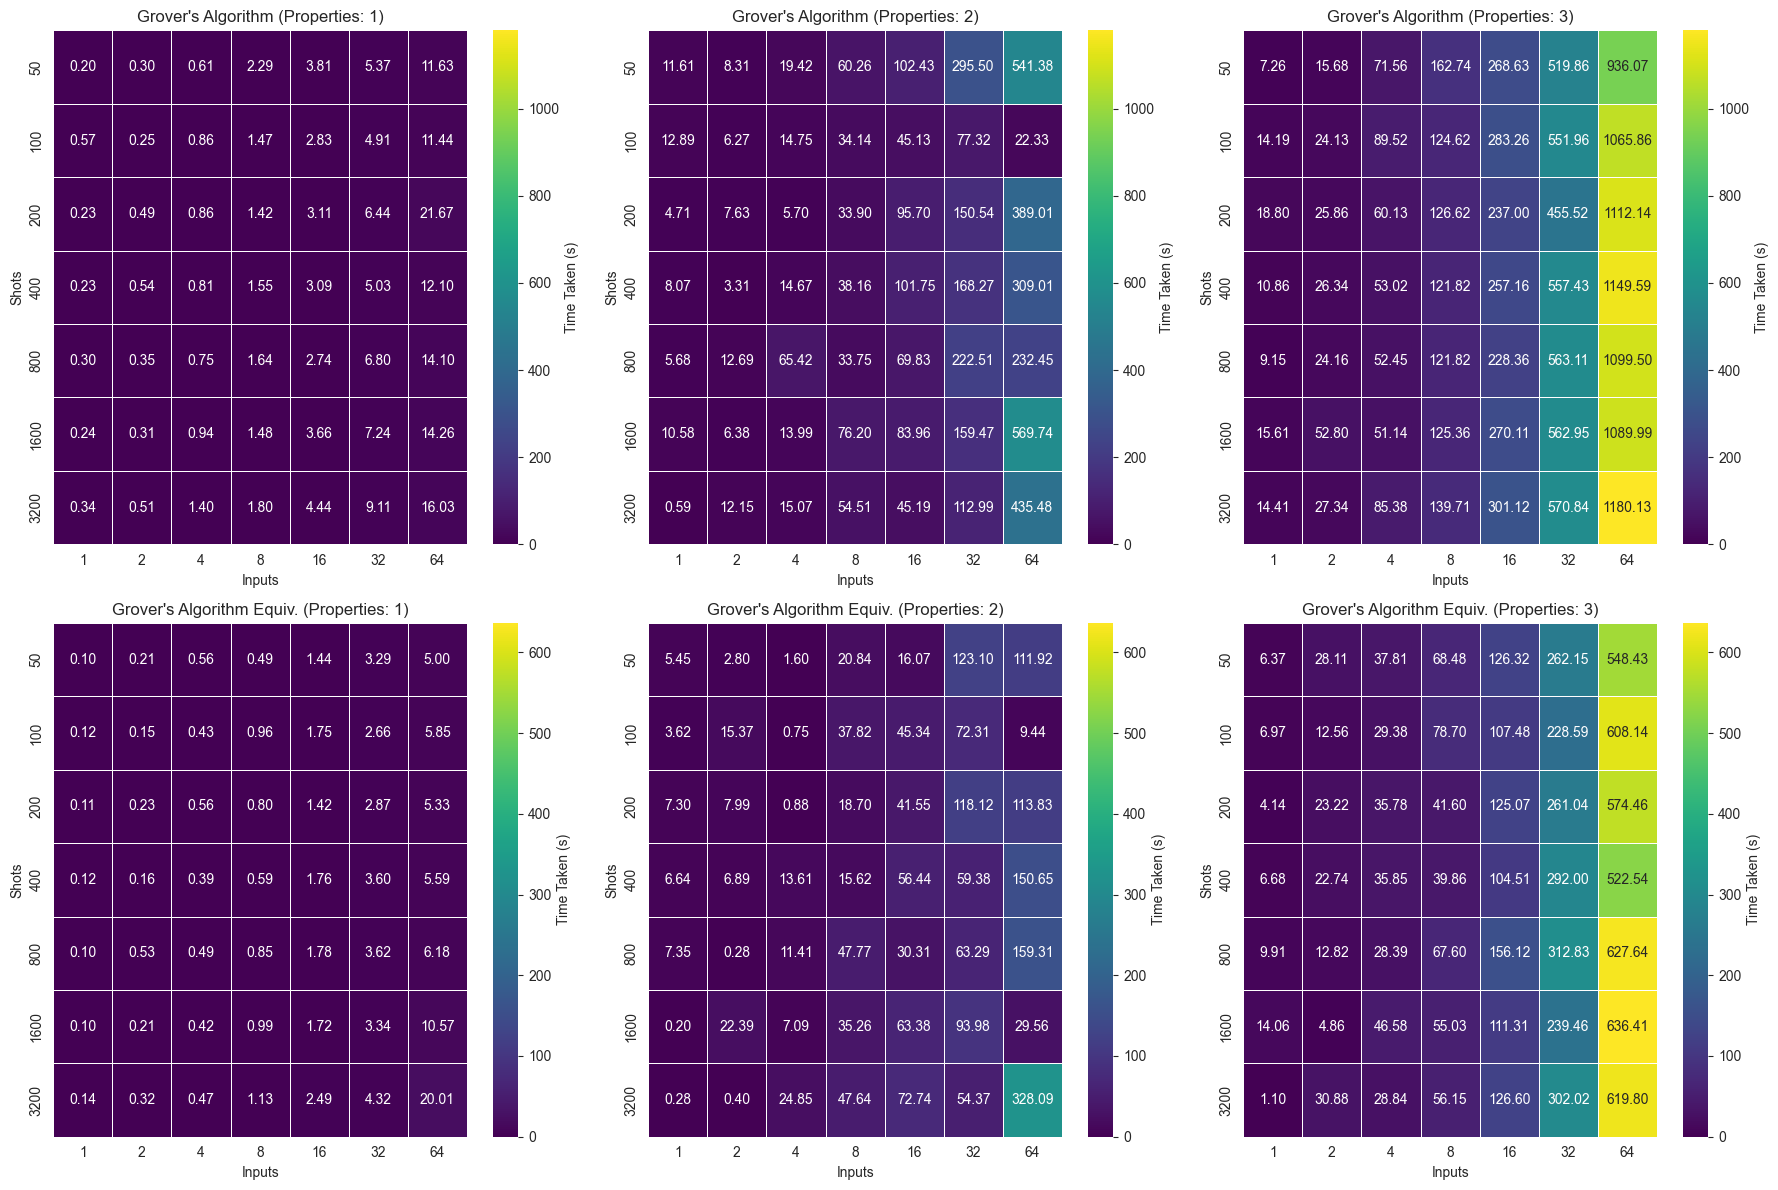

In [25]:
plot_time_taken(grover_df, "Grover's Algorithm")

In [35]:
def read_merged_data_to_dataframe(algorithm_name, csv_filename):
    # Define the directory where the CSV files are stored
    filename = f"mutation_test_results/{algorithm_name}/{csv_filename}.csv"
    return pd.read_csv(filename)

qs_qt_df = read_merged_data_to_dataframe("quantum_teleportation", "QTQS_in_out")

In [36]:
qs_qt_df

,Mutant Name,Result,Time Taken,Number of Measurements,config,Number of Inputs
0,quantum_teleportation_m0,Fail,0.239,3200,40x80,64
1,quantum_teleportation_m1,Fail,0.227,3200,40x80,64
2,quantum_teleportation_m2,Pass,9.940,3200,40x80,64
3,quantum_teleportation_m3,Pass,10.111,3200,40x80,64
4,quantum_teleportation_m4,Pass,9.938,3200,40x80,64
5,quantum_teleportation_m5,Fail,0.377,3200,40x80,64
6,quantum_teleportation_m6,Fail,0.260,3200,40x80,64
7,quantum_teleportation_m7,Fail,0.271,3200,40x80,64
8,quantum_teleportation_m8,Pass,10.266,3200,40x80,64
9,quantum_teleportation_m9,Pass,10.740,3200,40x80,64


In [37]:
qt_df

,Mutant Name,Number of Properties,Number of Inputs,Number of Measurements,Result,Number of Circuits Executed,Number of Unique Failed Properties,Number of Failed Properties,Unique Failed Properties,Time Taken
0,quantum_teleportation_m0,1,16,100,Fail,96,1,16,Inq0EqualOutq2,0.181780
1,quantum_teleportation_m1,1,16,100,Fail,96,1,12,Inq0EqualOutq2,0.164276
2,quantum_teleportation_m2,1,16,100,Fail,96,1,11,Inq0EqualOutq2,0.224850
3,quantum_teleportation_m3,1,16,100,Fail,96,1,16,Inq0EqualOutq2,0.165184
4,quantum_teleportation_m4,1,16,100,Fail,51,1,13,NotTeleportedPlus,0.214385
...,...,...,...,...,...,...,...,...,...,...
2200,quantum_teleportation_em0,3,8,800,Pass,99,0,0,NaN,0.563711
2201,quantum_teleportation_em1,3,8,800,Fail,99,1,1,UnitaryBeforeAndAfterTeleport,0.475464
2202,quantum_teleportation_em2,3,8,800,Pass,99,0,0,NaN,0.563664
2203,quantum_teleportation_em3,3,8,800,Pass,99,0,0,NaN,0.478414


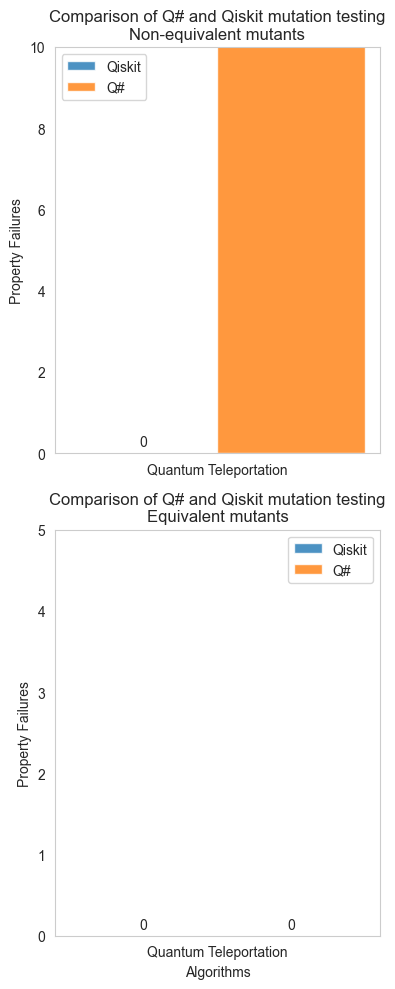

In [41]:
# plot the result for quantum teleportation, comparing QS and no QS
def plot_quantitative_analysis_comparison(feature_str):
    # get the number of failures for qs_qt_df
    qs_qt_df_non_equivalent = qs_qt_df[qs_qt_df['Mutant Name'].str.contains('_m')]
    qs_non_equiv_failures = (qs_qt_df_non_equivalent["Result"] == 'Fail').sum()
    
    qs_qt_df_equivalent = qs_qt_df[qs_qt_df['Mutant Name'].str.contains('_em')]
    qs_equiv_failures = (qs_qt_df_equivalent["Result"] == 'Fail').sum()
    
    # get the number of failures for qt_df
    qt_df_non_equivalent = qt_df[qt_df['Mutant Name'].str.contains('_m')]
    qt_df_non_equivalent = qt_df_non_equivalent[qt_df_non_equivalent['Number of Measurements'] == 2000]
    qt_df_non_equivalent = qt_df_non_equivalent[qt_df_non_equivalent['Number of Inputs'] == 25]
    qt_non_equiv_failures = (qt_df_non_equivalent[feature_str] == 'Fail').sum() 
    
    qt_df_equivalent = qt_df[qt_df['Mutant Name'].str.contains('_em')]
    qt_df_equivalent = qt_df_equivalent[qt_df_equivalent['Number of Measurements'] == 2000]
    qt_df_equivalent = qt_df_equivalent[qt_df_equivalent['Number of Inputs'] == 25]
    qt_equiv_failures = (qt_df_equivalent[feature_str] == 'Fail').sum() 

    algorithms = ["Quantum Teleportation"]
    
    algorithms_results_qiskit_non_equiv = np.array([qt_non_equiv_failures])
    algorithms_results_qs_non_equiv = np.array([qs_non_equiv_failures])
    algorithms_results_qiskit_equiv = np.array([qt_equiv_failures])
    algorithms_results_qs_equiv = np.array([qs_equiv_failures])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 10))
    width = 0.25
    
    # Define x-positions for the bars
    x = np.arange(len(algorithms))
    
    # Create the bars for non-equivalent mutants
    rects1 = ax1.bar(x - width/2, algorithms_results_qiskit_non_equiv, width, label='Qiskit', alpha=0.8)
    rects2 = ax1.bar(x + width/2, algorithms_results_qs_non_equiv, width, label='Q#', alpha=0.8)
    
    # Customize the plot for non-equivalent mutants
    ax1.set_ylabel('Property Failures')
    ax1.set_title('Comparison of Q# and Qiskit mutation testing\nNon-equivalent mutants')
    ax1.set_xticks(x)
    ax1.set_xticklabels(algorithms)
    ax1.legend()
    
    # Add value labels on the bars
    ax1.bar_label(rects1, padding=3)
    ax1.bar_label(rects2, padding=3)
    
    ax1.set_ylim(0, 10) 
    ax1.grid(False)
    
    # Create the bars for equivalent mutants
    rects3 = ax2.bar(x - width/2, algorithms_results_qiskit_equiv, width, label='Qiskit', alpha=0.8)
    rects4 = ax2.bar(x + width/2, algorithms_results_qs_equiv, width, label='Q#', alpha=0.8)
    
    # Customize the plot for equivalent mutants
    ax2.set_ylabel('Property Failures')
    ax2.set_xlabel('Algorithms')
    ax2.set_title('Comparison of Q# and Qiskit mutation testing\nEquivalent mutants')
    ax2.set_xticks(x)
    ax2.set_xticklabels(algorithms)
    ax2.legend()
    
    # Add value labels on the bars
    ax2.bar_label(rects3, padding=3)
    ax2.bar_label(rects4, padding=3)
    
    ax2.set_ylim(0, 5) 
    ax2.grid(False)
    
    # Adjust layout and display
    fig.tight_layout()
    plt.show()

# Call the function
plot_quantitative_analysis_comparison("Result")

In [47]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import GlobalPhaseGate
from qiskit.quantum_info import Statevector
import numpy as np

In [51]:
qc = QuantumCircuit(1)
qc.rx(np.pi/2, 0)
qc.append(GlobalPhaseGate(np.pi/4), 0)
Statevector.from_instruction(qc)

Statevector([0.5+0.5j, 0.5-0.5j],
            dims=(2,))


In [44]:
qc = QuantumCircuit(1)
qc.sx(0)
Statevector.from_instruction(qc)


Statevector([0.5+0.5j, 0.5-0.5j],
            dims=(2,))
